This python code is used to analysis soil moisture memory

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
import shutil
from scipy.spatial import distance
import metpy

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import sys, os, time, warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

In [26]:
def sm_memory(a):
    nt = len(a.time)
    time_day = pd.date_range(start='1900-01-01', periods=nt, freq='D')
    a  = a.assign_coords({"time": (time_day)})
    a0 = a.isel(time=slice(0,nt-2))
    time_bk = time_day[:nt-2]
    a1 = a.isel(time=slice(1,nt-1)).assign_coords({"time": (time_bk)})
    a2 = a.isel(time=slice(2,nt-0)).assign_coords({"time": (time_bk)})
    
    lac1 = np.log( xr.corr(a0,a1,dim='time') )
    lac2 = np.log( xr.corr(a0,a2,dim='time') )
    mem = -1. / ( lac2 - lac1 )
    err = 2. * lac1 - lac2
    return mem, err

def cal_rmse(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    RMSE : xarray
        calculated RMSE
    """
    diff = ( b - a ) ** 2
    return ( diff.mean(dim) ) ** 0.5

def cal_bias(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    RMSE : xarray
        calculated RMSE
    """
    diff = ( b - a )
    return diff.mean(dim)

In [6]:
era_smm = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/ERA5_land_ssm_memory_map.nc4')['ssm']
sat_smm = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/ESACCI_ssm_memory_map.nc4')['ssm']
g5_smm = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/glosea5_ssm_memory_map.nc4')['ssm']
g6_smm = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/glosea6_ssm_memory_map.nc4')['ssm']

In [5]:
dir = '/land1/ISMN/231201/'
site_list = sorted(glob.glob(dir+'*.csv'))

lons = []
lats = []
site = []
flag = [np.nan] * len(site_list)
site_list2 = []

for ff,f in enumerate(site_list):
    network = f.split("/")[4].split("_")[1]
    # print(network)
    # sys.exit()
    df = pd.read_csv(f,na_values=-9999)
    df['date_time'] = pd.to_datetime(df['date_time'])
    # df2 = df.groupby(pd.Grouper(key='date_time', freq='D'))['soil_moisture'].mean()
    
    syr = df['date_time'].dt.year.min()
    eyr = df['date_time'].dt.year.max()
    
    if ( ( syr >= 2000 ) & ( syr <= 2016 ) ) | ( ( eyr >= 2000 ) & ( eyr <= 2016 ) ):
        if network != 'SNOTEL':
            lons.append(df['longitude'][0])
            lats.append(df['latitude'][0])
            site.append(df['station'][0])
            site_list2.append(f)
            flag[ff] = 1

In [16]:
time = pd.date_range(start='2000-01-01', end='2016-12-31', freq='1D')

obs_sm = xr.DataArray(data = np.empty([len(time),len(site_list2)]) * np.nan, 
                      dims=["time","site"],
                      coords = dict(time=(["time"], time),
                                    site=(["site"], [x for x in range(len(site_list2))]),
                                   )
                     )


for ff,f in enumerate(site_list2):
    # print(ff,f)
    df = pd.read_csv(f,na_values=-9999)
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    df2 = df.groupby(pd.Grouper(key='date_time', freq='D'))['soil_moisture'].mean()
    del df
    
    sd = df2.index[0] > obs_sm.time[0].values
    ed = df2.index[len(df2)-1] > obs_sm.time[len(time)-1].values
    # del df2
       
    if sd == True and ed == True:
        t1 = list(obs_sm.time.values).index(obs_sm.sel(time=df2.index[0]).time)
        t2 = list(obs_sm.time.values).index(obs_sm.sel(time=obs_sm.time[len(time)-1].values).time)
        obs_sm[t1:t2+1,ff] = df2[df2.index[0]:obs_sm.time[len(time)-1].values]
    elif sd == True and ed == False:
        t1 = list(obs_sm.time.values).index(obs_sm.sel(time=df2.index[0]).time)
        t2 = list(obs_sm.time.values).index(obs_sm.sel(time=df2.index[len(df2)-1]).time)
        obs_sm[t1:t2+1,ff] = df2[df2.index[0]:df2.index[len(df2)-1]]
    elif sd == False and ed == False:
        t1 = list(obs_sm.time.values).index(obs_sm.sel(time=obs_sm.time[0].values).time)
        t2 = list(obs_sm.time.values).index(obs_sm.sel(time=df2.index[len(df2)-1]).time)
        obs_sm[t1:t2+1,ff] = df2[obs_sm.time[0].values:df2.index[len(df2)-1]]
    elif sd == False and ed == True:
        t1 = list(obs_sm.time.values).index(obs_sm.sel(time=obs_sm.time[0].values).time)
        t2 = list(obs_sm.time.values).index(obs_sm.sel(time=obs_sm.time[len(time)-1].values).time)
        obs_sm[t1:t2+1,ff] = df2[obs_sm.time[0].values:obs_sm.time[len(time)-1].values]

obs_sm = obs_sm.to_dataset(name='ssm')
obs_sm.to_netcdf(path='./data/ISMN_ssm_2000-2016.nc4',engine="netcdf4",unlimited_dims="time",format="netCDF4")
del obs_sm

In [17]:
obs = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/ISMN_ssm_2000-2016.nc4')['ssm']
obs_smm,_ = sm_memory( obs.sel(time=( (obs.time.dt.month>=6) & (obs.time.dt.month<=8) )) )
del obs

In [175]:
era_smm2 = era_smm.sel(lat=lats,lon=lons,method='nearest')
sat_smm2 = sat_smm.sel(lat=lats,lon=lons,method='nearest')
g5_smm2  = g5_smm.sel(lat=lats,lon=lons,method='nearest')
g6_smm2  = g6_smm.sel(lat=lats,lon=lons,method='nearest')

era_smm3 = xr.DataArray(data = np.empty([len(site_list2)]) * np.nan,
                        dims=["site"],
                        coords = dict(site=(["site"], [x for x in range(len(site_list2))]),
                                     )
                       )
sat_smm3 = era_smm3.copy(deep=True)
g5_smm3 = era_smm3.copy(deep=True)
g6_smm3 = era_smm3.copy(deep=True)
obs_sm = era_smm3.copy(deep=True)

for ff,f in enumerate(site_list2):
    # print(ff,f)
    if ( obs_smm[ff] >= 1 ) and ( obs_smm[ff] <= 30 ):
        era_smm3[ff] = era_smm2.isel(lat=ff,lon=ff)
        sat_smm3[ff] = sat_smm2.isel(lat=ff,lon=ff)
        g5_smm3[ff]  = g5_smm2.isel(lat=ff,lon=ff)
        g6_smm3[ff]  = g6_smm2.isel(lat=ff,lon=ff)
        obs_sm[ff] = obs.isel(site=ff).sel(time=( (obs.time.dt.month>=6) & (obs.time.dt.month<=8) )).mean(dim='time')

In [176]:
mask3 = ( ~np.isnan(obs_smm) ) & ( ~np.isnan(era_smm3) ) & ( ~np.isnan(sat_smm3) ) & ( ~np.isnan(g5_smm3) ) & ( ~np.isnan(g6_smm3) )

obs_smm4 = obs_smm[mask3]
era_smm4 = era_smm3[mask3]
sat_smm4 = sat_smm3[mask3]
g5_smm4  = g5_smm3[mask3]
g6_smm4  = g6_smm3[mask3]
obs_sm_clim = obs_sm[mask3]

In [63]:
c1 = xr.corr(obs_smm4,era_smm4,'site')
c2 = xr.corr(obs_smm4,sat_smm4,'site')
c3 = xr.corr(obs_smm4,g5_smm4,'site')
c4 = xr.corr(obs_smm4,g6_smm4,'site')
print(c1,c2,c3,c4)

<xarray.DataArray ()>
array(0.14451075) <xarray.DataArray ()>
array(0.34794386) <xarray.DataArray ()>
array(0.13569355) <xarray.DataArray ()>
array(0.29897851)


In [64]:
c1 = cal_bias(obs_smm4,era_smm4,'site')
c2 = cal_bias(obs_smm4,sat_smm4,'site')
c3 = cal_bias(obs_smm4,g5_smm4,'site')
c4 = cal_bias(obs_smm4,g6_smm4,'site')
print(c1,c2,c3,c4)

<xarray.DataArray ()>
array(-3.82579756) <xarray.DataArray ()>
array(-2.35353) <xarray.DataArray ()>
array(-2.77073933) <xarray.DataArray ()>
array(-2.36384981)


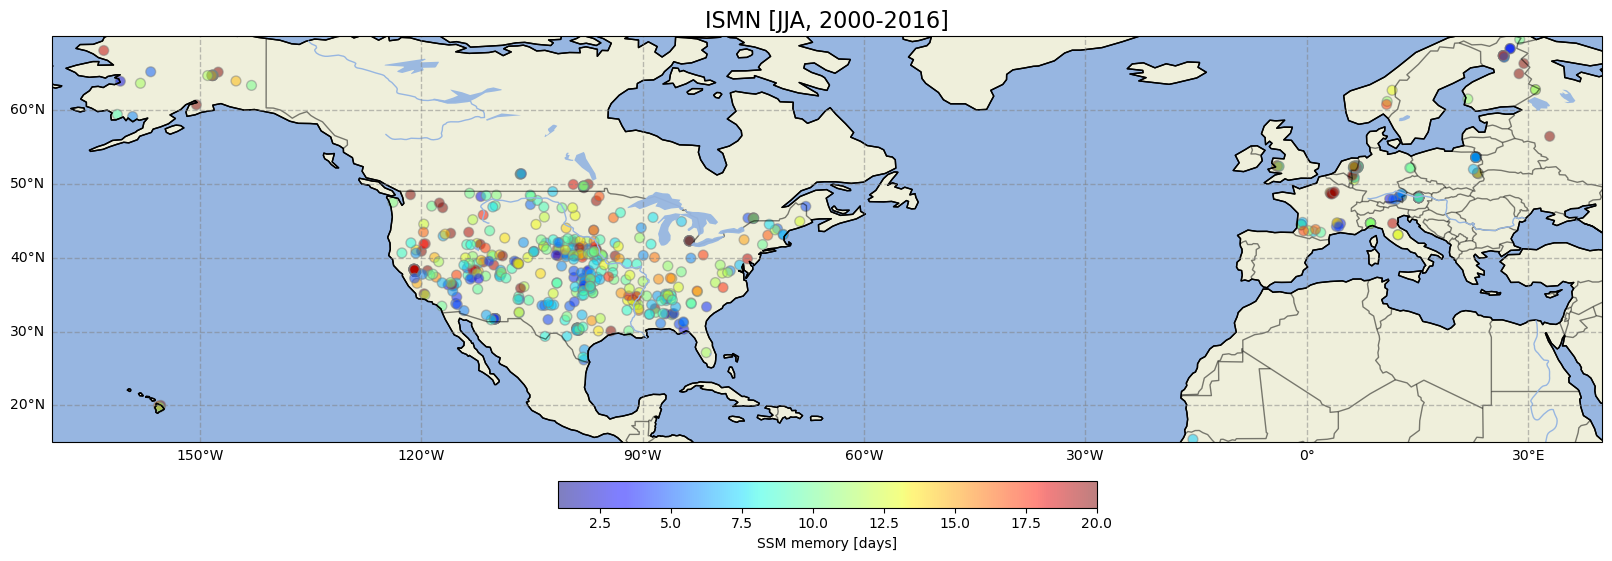

In [101]:
fname = './fig/ismn_ssm_memory_map.png'
data = obs_smm4
cmaps = 'jet'
cmin = 1
cmax = 20
title = 'ISMN [JJA, 2000-2016]'

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.scatter(np.array(lons)[mask3], np.array(lats)[mask3], c=data, cmap=cmaps, transform=ccrs.PlateCarree(),vmax=cmax,vmin=cmin,s=50,alpha=0.5, edgecolor='gray')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-170, 40, 15, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False



textstr1="\n".join(( 
    f'N=%.0f ' %(len(data)), 
    f'SMM=%.3f m$^3$/m$^3$' %(np.mean(data))
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.55,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.colorbar(label='SSM memory [days]', orientation='horizontal', fraction=0.035, pad=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('{}'.format(title), fontsize=16)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

<xarray.DataArray ()>
array(7.52052138) <xarray.DataArray ()>
array(-3.82579756) 0.14451074562437657 1.2338736017582728e-05


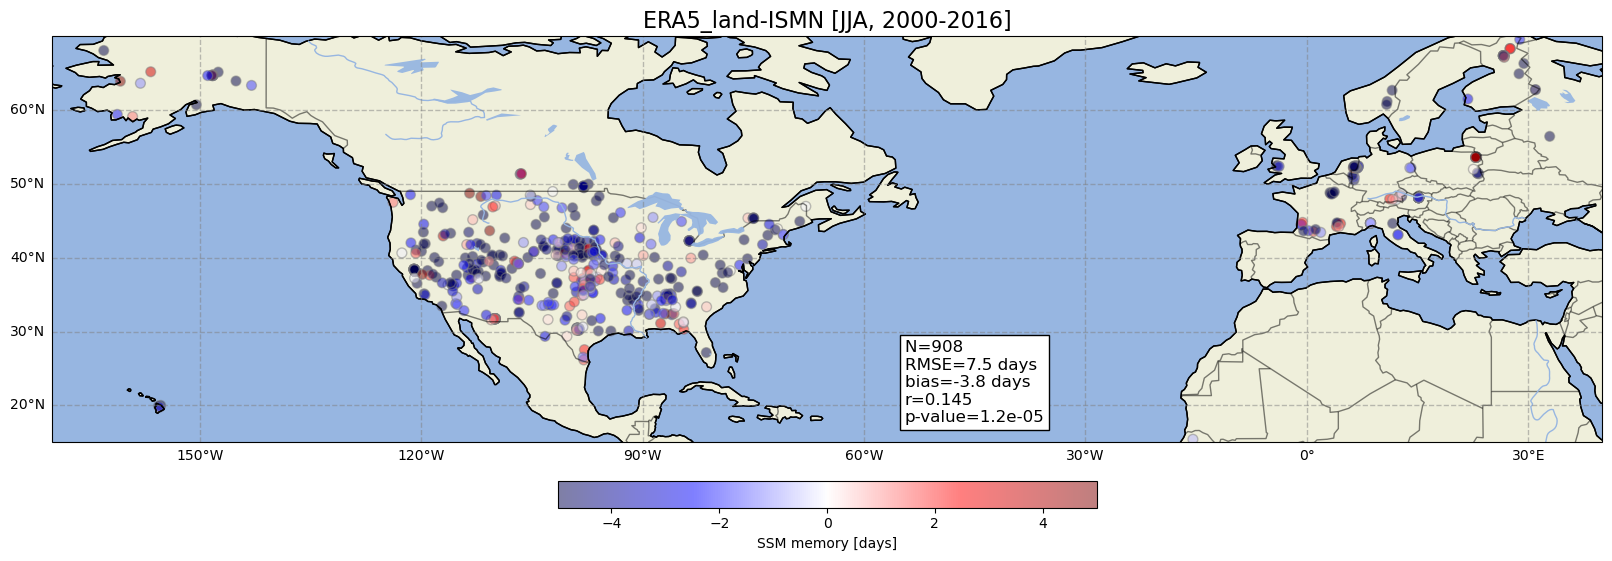

In [102]:
fname = './fig/era5-land_ssm_memory_bias_map.png'
x1 = era_smm4
y1 = obs_smm4
mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 
x = x1[mask]
y = y1[mask]
data = x1 - y1
cmaps = 'seismic'
cmin = -5
cmax = 5
title = 'ERA5_land-ISMN [JJA, 2000-2016]'

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.scatter(np.array(lons)[mask3], np.array(lats)[mask3], c=data, cmap=cmaps, transform=ccrs.PlateCarree(),vmax=cmax,vmin=cmin,s=50,alpha=0.5, edgecolor='gray')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-170, 40, 15, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

rmse = cal_rmse(y1,x1,'site')
bias = cal_bias(y1,x1,'site')
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)

textstr1="\n".join(( 
    f'N=%.0f ' %(mask.sum().item()), 
    f'RMSE=%.1f days' %(rmse), 
    f'bias=%.1f days' %(bias), 
    f'r=%.3f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.55,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.colorbar(label='SSM memory [days]', orientation='horizontal', fraction=0.035, pad=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('{}'.format(title), fontsize=16)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

<xarray.DataArray ()>
array(6.53290871) <xarray.DataArray ()>
array(-2.35353) 0.34794386438523406 3.0957646405627136e-27


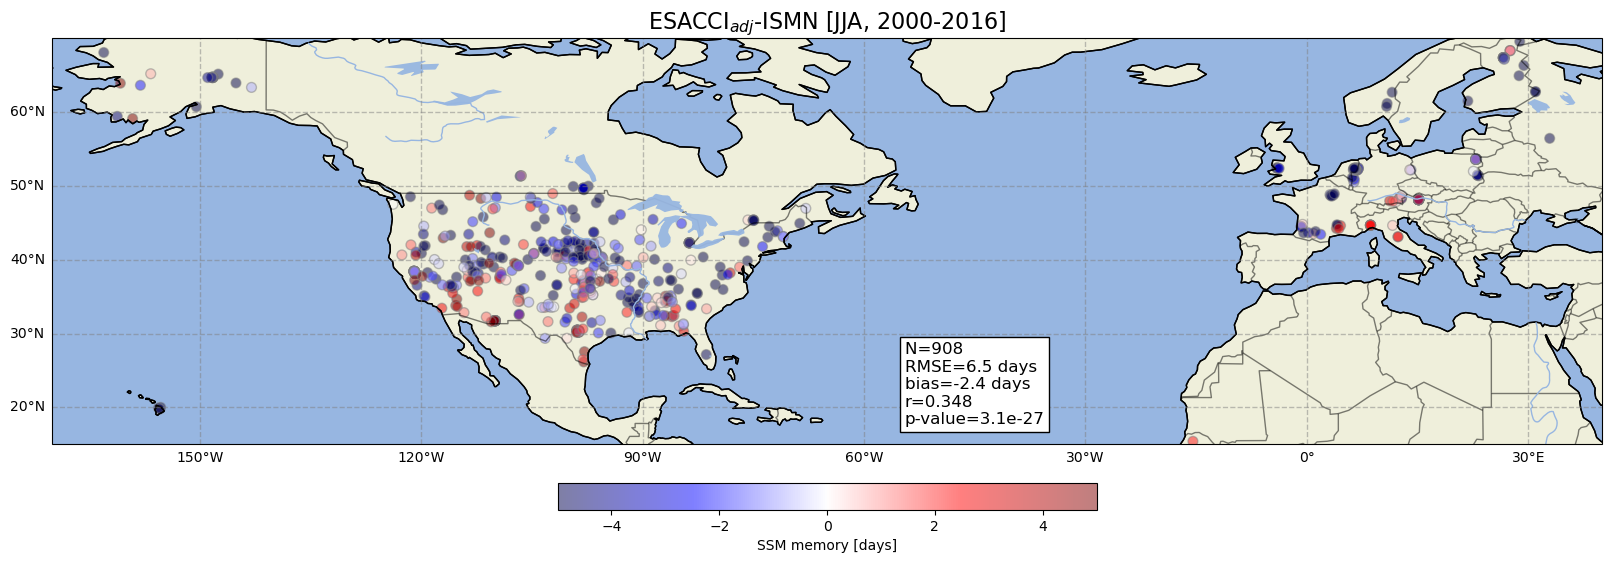

In [103]:
fname = './fig/CCI_ssm_memory_bias_map.png'
x1 = sat_smm4
y1 = obs_smm4
mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 
x = x1[mask]
y = y1[mask]
data = x1 - y1
cmaps = 'seismic'
cmin = -5
cmax = 5
title = 'ESACCI$_{adj}$-ISMN [JJA, 2000-2016]'

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))

plt.scatter(np.array(lons)[mask3], np.array(lats)[mask3], c=data, cmap=cmaps, transform=ccrs.PlateCarree(),vmax=cmax,vmin=cmin,s=50,alpha=0.5, edgecolor='gray')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-170, 40, 15, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False




rmse = cal_rmse(y1,x1,'site')
bias = cal_bias(y1,x1,'site')
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)


textstr1="\n".join(( 
    f'N=%.0f ' %(mask.sum().item()), 
    f'RMSE=%.1f days' %(rmse), 
    f'bias=%.1f days' %(bias), 
    f'r=%.3f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.55,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.colorbar(label='SSM memory [days]', orientation='horizontal', fraction=0.035, pad=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('{}'.format(title), fontsize=16)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

<xarray.DataArray ()>
array(7.13476095) <xarray.DataArray ()>
array(-2.77073933) 0.13569355049446588 4.092157437344203e-05


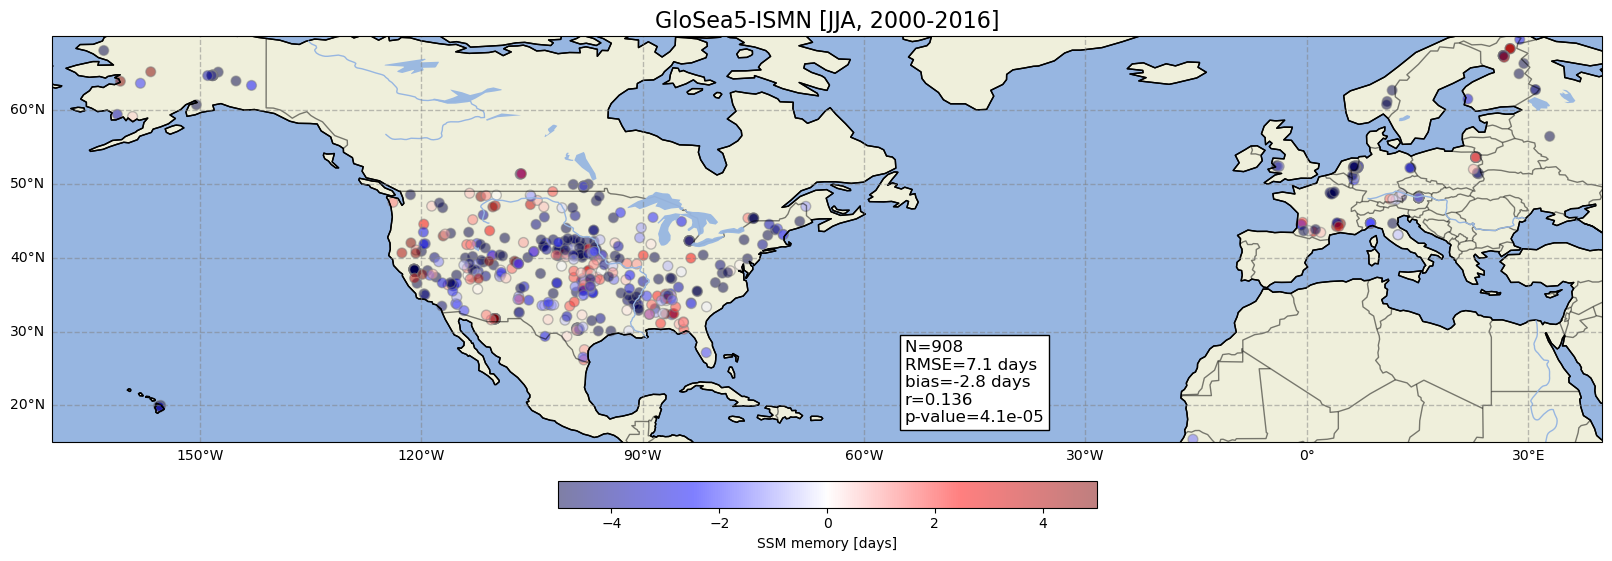

In [104]:
fname = './fig/G5_ssm_memory_bias_map.png'
x1 = g5_smm4
y1 = obs_smm4
mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 
x = x1[mask]
y = y1[mask]
data = x1 - y1
cmaps = 'seismic'
cmin = -5
cmax = 5
title = 'GloSea5-ISMN [JJA, 2000-2016]'

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.scatter(np.array(lons)[mask3], np.array(lats)[mask3], c=data, cmap=cmaps, transform=ccrs.PlateCarree(),vmax=cmax,vmin=cmin,s=50,alpha=0.5, edgecolor='gray')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-170, 40, 15, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


rmse = cal_rmse(y1,x1,'site')
bias = cal_bias(y1,x1,'site')
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)


textstr1="\n".join(( 
    f'N=%.0f ' %(mask.sum().item()), 
    f'RMSE=%.1f days' %(rmse), 
    f'bias=%.1f days' %(bias), 
    f'r=%.3f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.55,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.colorbar(label='SSM memory [days]', orientation='horizontal', fraction=0.035, pad=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('{}'.format(title), fontsize=16)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

<xarray.DataArray ()>
array(6.61097486) <xarray.DataArray ()>
array(-2.36384981) 0.298978507477064 3.3178538174744096e-20


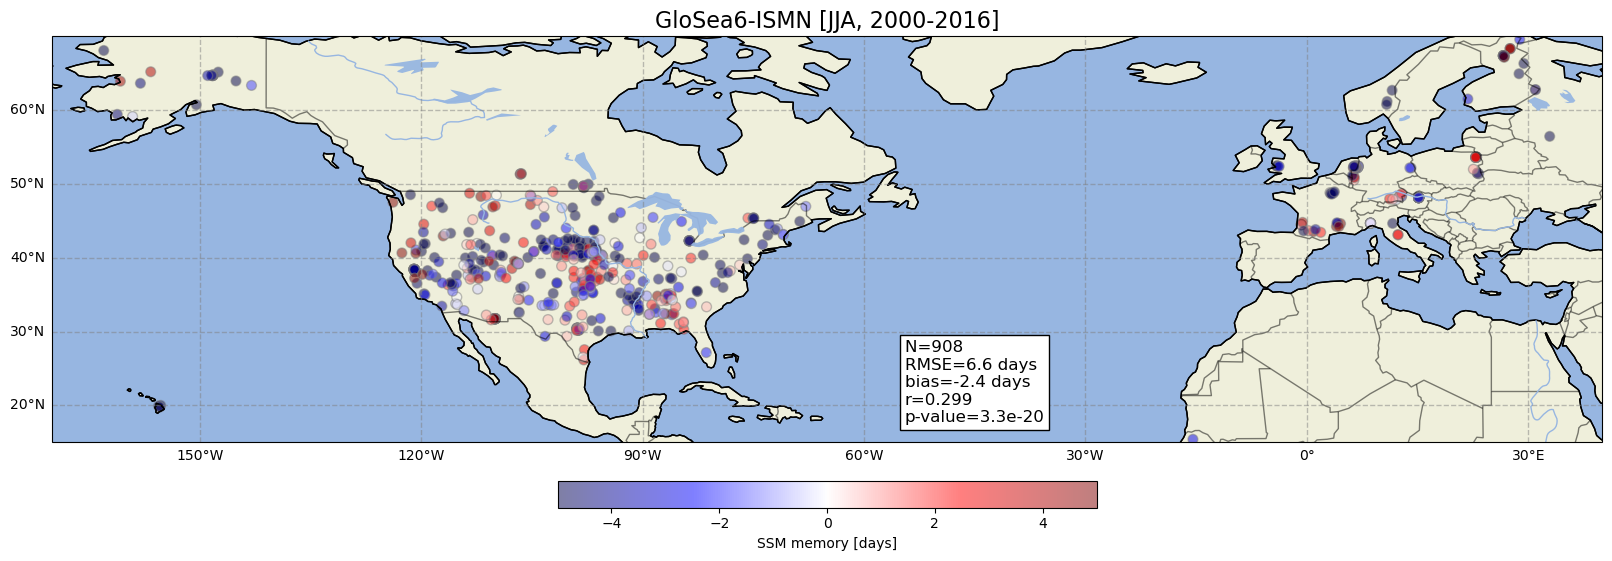

In [105]:
fname = './fig/G6_ssm_memory_bias_map.png'
x1 = g6_smm4
y1 = obs_smm4
mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 
x = x1[mask]
y = y1[mask]
data = x1 - y1
cmaps = 'seismic'
cmin = -5
cmax = 5
title = 'GloSea6-ISMN [JJA, 2000-2016]'

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.scatter(np.array(lons)[mask3], np.array(lats)[mask3], c=data, cmap=cmaps, transform=ccrs.PlateCarree(),vmax=cmax,vmin=cmin,s=50,alpha=0.5, edgecolor='gray')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-170, 40, 15, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


rmse = cal_rmse(y1,x1,'site')
bias = cal_bias(y1,x1,'site')
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)


textstr1="\n".join(( 
    f'N=%.0f ' %(mask.sum().item()), 
    f'RMSE=%.1f days' %(rmse), 
    f'bias=%.1f days' %(bias), 
    f'r=%.3f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.55,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.colorbar(label='SSM memory [days]', orientation='horizontal', fraction=0.035, pad=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('{}'.format(title), fontsize=16)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

<xarray.DataArray ()>
array(7.52052138) <xarray.DataArray ()>
array(-3.82579756) 0.14451074562437657 1.2338736017582728e-05


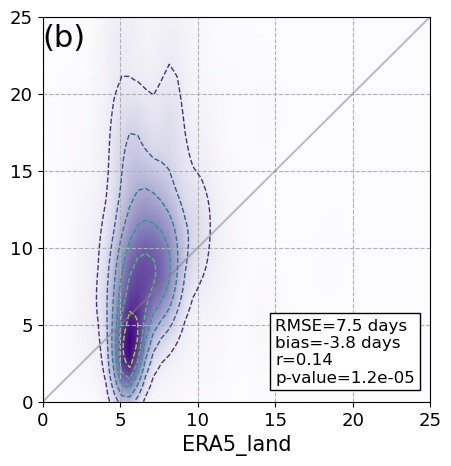

In [128]:
fname = './ismn_era5-land_sm_memory_scatter.png'
xlabels = 'ERA5_land'
ylabels = ''
titles = '(b)'
x1 = era_smm4
y1 = obs_smm4

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

from scipy import stats

mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 

x = x1[mask]
y = y1[mask]

rmse = cal_rmse(y1,x1,'site')
bias = cal_bias(y1,x1,'site')
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)

data = np.column_stack((x, y))
nbins = 50
xmin = 0. ; xmax = 25; ymin = 0. ; ymax = 25

k = stats.gaussian_kde(data.T)
xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
fig, ax = plt.subplots(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Purples')
plt.contour(xi, yi, zi.reshape(xi.shape), linewidths=1, linestyles='dashed', cmap='viridis')
plt.xlabel('{}'.format(xlabels), fontsize=15)
plt.ylabel('{}'.format(ylabels), fontsize=15)
plt.grid(True, linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', which='major', labelsize=13)
# ax.tick_params(axis='both', which='minor', labelsize=8)
add_identity(ax, color='gray', ls='-', alpha=0.5)

# textstr1="\n".join(( 
#     f'N=%.0f ' %(len(flag)), 
#     f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
#     f'bias=%.3f m$^3$/m$^3$' %(bias), 
#     f'r=%.3f' %(corr), 
#     f'p-value=%.1e' %(pval) 
# ))
textstr1="\n".join(( 
    f'RMSE=%.1f days' %(rmse), 
    f'bias=%.1f days' %(bias), 
    f'r=%.2f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.6,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.title('{}'.format(titles), loc='left', y=0.9, fontsize=22)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

<xarray.DataArray ()>
array(6.53290871) <xarray.DataArray ()>
array(-2.35353) 0.34794386438523406 3.0957646405627136e-27


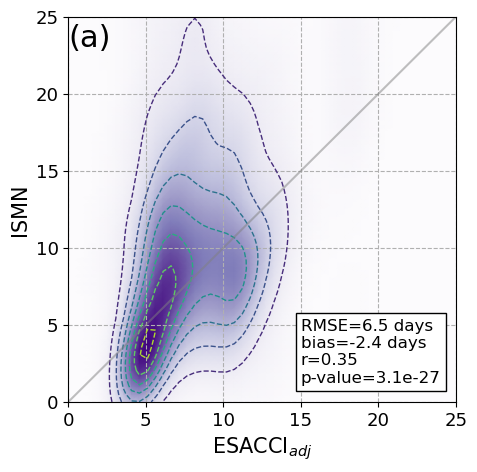

In [127]:
fname = './ismn_CCI_sm_memory_scatter.png'
xlabels = 'ESACCI$_{adj}$'
ylabels = 'ISMN'
titles = '(a)'
x1 = sat_smm4
y1 = obs_smm4

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

from scipy import stats

mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 

x = x1[mask]
y = y1[mask]

rmse = cal_rmse(y1,x1,'site')
bias = cal_bias(y1,x1,'site')
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)

data = np.column_stack((x, y))
nbins = 50
xmin = 0. ; xmax = 25; ymin = 0. ; ymax = 25

k = stats.gaussian_kde(data.T)
xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
fig, ax = plt.subplots(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Purples')
plt.contour(xi, yi, zi.reshape(xi.shape), linewidths=1, linestyles='dashed', cmap='viridis')
plt.xlabel('{}'.format(xlabels), fontsize=15)
plt.ylabel('{}'.format(ylabels), fontsize=15)
plt.grid(True, linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', which='major', labelsize=13)
# ax.tick_params(axis='both', which='minor', labelsize=8)
add_identity(ax, color='gray', ls='-', alpha=0.5)

# textstr1="\n".join(( 
#     f'N=%.0f ' %(len(flag)), 
#     f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
#     f'bias=%.3f m$^3$/m$^3$' %(bias), 
#     f'r=%.3f' %(corr), 
#     f'p-value=%.1e' %(pval) 
# ))
textstr1="\n".join(( 
    f'RMSE=%.1f days' %(rmse), 
    f'bias=%.1f days' %(bias), 
    f'r=%.2f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.6,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.title('{}'.format(titles), loc='left', y=0.9, fontsize=22)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

<xarray.DataArray ()>
array(7.13476095) <xarray.DataArray ()>
array(-2.77073933) 0.13569355049446588 4.092157437344203e-05


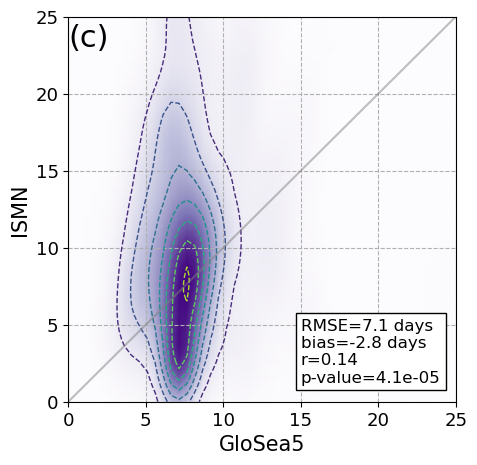

In [125]:
fname = './ismn_g5_sm_memory_scatter.png'
xlabels = 'GloSea5'
ylabels = 'ISMN'
titles = '(c)'
x1 = g5_smm4
y1 = obs_smm4

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

from scipy import stats

mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 

x = x1[mask]
y = y1[mask]

rmse = cal_rmse(y1,x1,'site')
bias = cal_bias(y1,x1,'site')
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)

data = np.column_stack((x, y))
nbins = 50
xmin = 0. ; xmax = 25; ymin = 0. ; ymax = 25

k = stats.gaussian_kde(data.T)
xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
fig, ax = plt.subplots(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Purples')
plt.contour(xi, yi, zi.reshape(xi.shape), linewidths=1, linestyles='dashed', cmap='viridis')
plt.xlabel('{}'.format(xlabels), fontsize=15)
plt.ylabel('{}'.format(ylabels), fontsize=15)
plt.grid(True, linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', which='major', labelsize=13)
# ax.tick_params(axis='both', which='minor', labelsize=8)
add_identity(ax, color='gray', ls='-', alpha=0.5)

# textstr1="\n".join(( 
#     f'N=%.0f ' %(len(flag)), 
#     f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
#     f'bias=%.3f m$^3$/m$^3$' %(bias), 
#     f'r=%.3f' %(corr), 
#     f'p-value=%.1e' %(pval) 
# ))
textstr1="\n".join(( 
    f'RMSE=%.1f days' %(rmse), 
    f'bias=%.1f days' %(bias), 
    f'r=%.2f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.6,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.title('{}'.format(titles), loc='left', y=0.9, fontsize=22)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

<xarray.DataArray ()>
array(6.61097486) <xarray.DataArray ()>
array(-2.36384981) 0.298978507477064 3.3178538174744096e-20


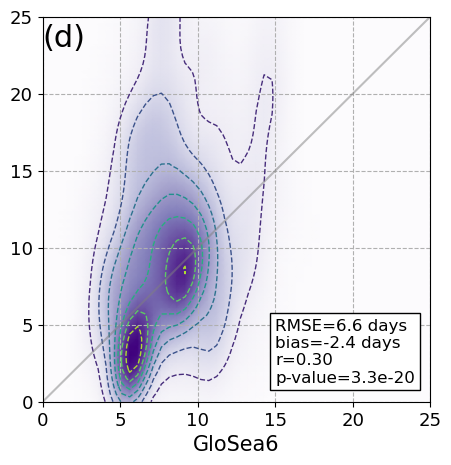

In [126]:
fname = './ismn_g6_sm_memory_scatter.png'
xlabels = 'GloSea6'
ylabels = ''
titles = '(d)'
x1 = g6_smm4
y1 = obs_smm4

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

from scipy import stats

mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 

x = x1[mask]
y = y1[mask]

rmse = cal_rmse(y1,x1,'site')
bias = cal_bias(y1,x1,'site')
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)

data = np.column_stack((x, y))
nbins = 50
xmin = 0. ; xmax = 25; ymin = 0. ; ymax = 25

k = stats.gaussian_kde(data.T)
xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
fig, ax = plt.subplots(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Purples')
plt.contour(xi, yi, zi.reshape(xi.shape), linewidths=1, linestyles='dashed', cmap='viridis')
plt.xlabel('{}'.format(xlabels), fontsize=15)
plt.ylabel('{}'.format(ylabels), fontsize=15)
plt.grid(True, linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', which='major', labelsize=13)
# ax.tick_params(axis='both', which='minor', labelsize=8)
add_identity(ax, color='gray', ls='-', alpha=0.5)

# textstr1="\n".join(( 
#     f'N=%.0f ' %(len(flag)), 
#     f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
#     f'bias=%.3f m$^3$/m$^3$' %(bias), 
#     f'r=%.3f' %(corr), 
#     f'p-value=%.1e' %(pval) 
# ))
textstr1="\n".join((
    f'RMSE=%.1f days' %(rmse), 
    f'bias=%.1f days' %(bias), 
    f'r=%.2f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.6,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.title('{}'.format(titles), loc='left', y=0.9, fontsize=22)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

In [161]:
vfile = sorted(glob.glob('/home/eseo/CCI/time_filter/CCI_v2/v6.1/postprocess/glb/CCI_v2_ssm_*.nc'))
data = xr.open_mfdataset(vfile,concat_dim='time',combine='nested')['ssm'].sel(time=slice('2000-01-01','2016-12-31'))
sat = data.sel(time=( (data.time.dt.month>=6) & (data.time.dt.month<=8) ), lon=np.array(lons)[mask3], lat=np.array(lats)[mask3], method='nearest').mean(dim='time')
del data

In [134]:
vfile = sorted(glob.glob('/land2/ERA5_land/daily/*/20*_sm.nc'))
# print(vfile[:17*12])
# sys.exit()
data = xr.open_mfdataset(vfile[:17*12],concat_dim='time',combine='nested')['swvl1']#.sel(time=slice('2000-01-01','2016-12-31'))
data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180
data = data.sortby(data.longitude)
era = data.rename({'longitude': 'lon', 'latitude': 'lat'}).sel(time=( (data.time.dt.month>=6) & (data.time.dt.month<=8) ), lon=np.array(lons)[mask3], lat=np.array(lats)[mask3], method='nearest').mean(dim='time')

In [145]:
import xesmf as xe
var_name = 'sm'

vfile = sorted(glob.glob('/land1/GloSea/G6_HCST/'+var_name+'/*.nc'))
data = xr.open_dataset(vfile[0])
data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180
data = data.sortby(data.longitude).sel(latitude=slice(-60,90))
ds_out = xr.Dataset({"lat": (["lat"], data.latitude.values), "lon": (["lon"], data.longitude.values), })

vfile = sorted(glob.glob('/home/eseo/CCI/time_filter/CCI_v2/v6.1/postprocess/glb/CCI_v2_ssm_*.nc'))
data = xr.open_mfdataset(vfile,concat_dim='time',combine='nested')['time'].sel(time=slice('2000-01-01','2016-12-31'))
time_bk = data.sel(time=( (data.time.dt.month>=6) & (data.time.dt.month<=8) ))

In [162]:
ens_g5 = 3
ens_g6 = 7

syear = 2000
eyear = 2016
    
years = [x for x in range(syear,eyear+1)]

g5_sm = xr.DataArray(data = np.empty([ens_g5,len(time_bk),len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                     dims=["ensembles","time","lat","lon"],
                     coords = dict(ensembles=(["ensembles"], [x for x in range(ens_g5)]),
                                   time=(["time"], time_bk.values),
                                   lat=(["lat"], ds_out.lat.values),
                                   lon=(["lon"], ds_out.lon.values),
                                  )
                    )

for y,yr in enumerate(years):
    print(yr)
    dir = '/land1/GloSea/G5_HCST/'   
    vfile = sorted(glob.glob(dir+'/sm/'+str(yr)+'0601_*.nc'))
    data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sm'].isel(level6=0)
    data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
    data1 = data1.sortby(data1.longitude)
    data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
    t1 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-06-01'))
    t2 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-06-30'))
    g5_sm[:,t1:t2+1,:,:] = data1.sel(time=(data1.time.dt.month==6)).values
    del data1, vfile, t1, t2
    
    vfile = sorted(glob.glob(dir+'/sm/'+str(yr)+'0701_*.nc'))
    data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sm'].isel(level6=0)
    data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
    data1 = data1.sortby(data1.longitude)
    data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
    t1 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-07-01'))
    t2 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-07-31'))
    g5_sm[:,t1:t2+1,:,:] = data1.sel(time=(data1.time.dt.month==7)).values
    del data1, vfile, t1, t2
    
    vfile = sorted(glob.glob(dir+'/sm/'+str(yr)+'0801_*.nc'))
    data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sm'].isel(level6=0)
    data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
    data1 = data1.sortby(data1.longitude)
    data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
    t1 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-08-01'))
    t2 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-08-31'))
    g5_sm[:,t1:t2+1,:,:] = data1.sel(time=(data1.time.dt.month==8)).values
    del data1, vfile, t1, t2
    
    
g5 = g5_sm.mean(dim=('ensembles','time')).sel(lon=np.array(lons)[mask3], lat=np.array(lats)[mask3], method='nearest')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


MemoryError: Unable to allocate 28.8 GiB for an array with shape (3, 1564, 908, 908) and data type float64

In [167]:
ens_g5 = 3
ens_g6 = 7

syear = 2000
eyear = 2016
    
years = [x for x in range(syear,eyear+1)]

g6_sm = xr.DataArray(data = np.empty([ens_g6,len(time_bk),len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                     dims=["ensembles","time","lat","lon"],
                     coords = dict(ensembles=(["ensembles"], [x for x in range(ens_g6)]),
                                   time=(["time"], time_bk.values),
                                   lat=(["lat"], ds_out.lat.values),
                                   lon=(["lon"], ds_out.lon.values),
                                  )
                    )

for y,yr in enumerate(years):
    print(yr)
    dir = '/land1/GloSea/G6_HCST/'   
    vfile = sorted(glob.glob(dir+'/sm/'+str(yr)+'0601_*.nc'))
    data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sm'].isel(level6=0)
    data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
    data1 = data1.sortby(data1.longitude)
    data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
    t1 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-06-01'))
    t2 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-06-30'))
    g6_sm[:,t1:t2+1,:,:] = data1.sel(time=(data1.time.dt.month==6)).values
    del data1, vfile, t1, t2
    
    vfile = sorted(glob.glob(dir+'/sm/'+str(yr)+'0701_*.nc'))
    data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sm'].isel(level6=0)
    data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
    data1 = data1.sortby(data1.longitude)
    data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
    t1 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-07-01'))
    t2 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-07-31'))
    g6_sm[:,t1:t2+1,:,:] = data1.sel(time=(data1.time.dt.month==7)).values
    del data1, vfile, t1, t2
    
    vfile = sorted(glob.glob(dir+'/sm/'+str(yr)+'0801_*.nc'))
    data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sm'].isel(level6=0)
    data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
    data1 = data1.sortby(data1.longitude)
    data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
    t1 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-08-01'))
    t2 = list(time_bk.values).index(time_bk.sel(time=str(yr)+'-08-31'))
    g6_sm[:,t1:t2+1,:,:] = data1.sel(time=(data1.time.dt.month==8)).values
    del data1, vfile, t1, t2
    
    
g6 = g6_sm.mean(dim=('ensembles','time')).sel(lon=np.array(lons)[mask3], lat=np.array(lats)[mask3], method='nearest')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [ ]:
obs2 = obs_sm_clim.values
era2 = era.values
sat2 = sat.values
g52 = g5.values
g62 = g6.values

In [218]:
obs_clim = xr.DataArray(data = np.empty([len(obs_sm_clim)]) * np.nan,
                        dims=["site"],
                        coords = dict(site=(["site"], [x for x in range(len(obs_sm_clim))]),
                                     )
                       )                                         
sat_clim = obs_clim.copy(deep=True)
era_clim = obs_clim.copy(deep=True)
g5_clim  = obs_clim.copy(deep=True)
g6_clim  = obs_clim.copy(deep=True)

for ff in range(len(obs_sm_clim)):
    obs_clim[ff] = obs2[ff]
    sat_clim[ff] = sat2[ff,ff]
    era_clim[ff] = era2[ff,ff]
    g5_clim[ff] = g52[ff,ff]
    g6_clim[ff] = g62[ff,ff]

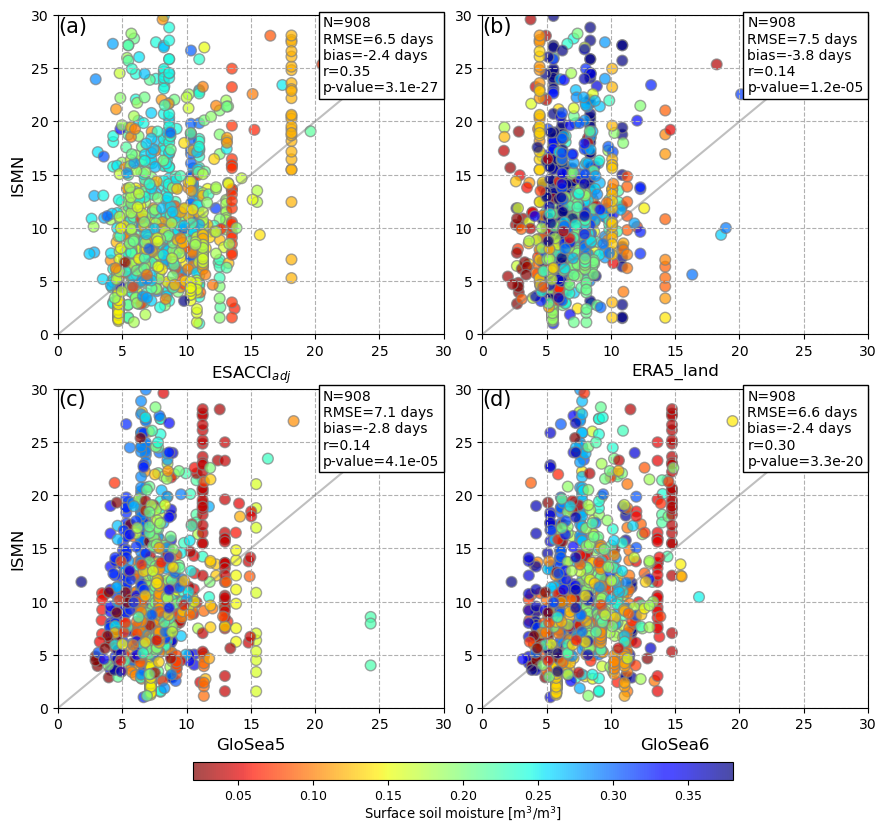

In [292]:
import string
from scipy import stats
alphabet = list(string.ascii_lowercase)


def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes



fname = './fig/sm_memory_scatter_mean.png'
xlabels = ['ESACCI$_{adj}$','ERA5_land','GloSea5','GloSea6']
ylabels = ['ISMN','','ISMN','']
xlim = [0, 30]
ylim = [0, 30]
vran = [0.02, 0.38]
# colormap = 'RdYlBu'
colormap = 'jet_r'
nrows = 2
ncols = 2

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        figsize=(9,9))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    if pp==0:
        x1 = sat_smm4
        y1 = obs_smm4
        z1 = sat_clim
    elif pp==1:
        x1 = era_smm4
        y1 = obs_smm4
        z1 = era_clim
    elif pp==2:
        x1 = g5_smm4
        y1 = obs_smm4
        z1 = g5_clim / 100.
    elif pp==3:
        x1 = g6_smm4
        y1 = obs_smm4
        z1 = g6_clim / 100.
        
    rmse = cal_rmse(y1,x1,'site')
    bias = cal_bias(y1,x1,'site')
    corr = stats.pearsonr(x1,y1)[0]
    pval = stats.pearsonr(x1,y1)[1]
    
    sc = axs[pp].scatter(x1, y1, s=60, c=z1, cmap=colormap, edgecolor='gray', alpha=0.7, vmin = vran[0], vmax =vran[1])
    axs[pp].set_xlim(xlim[0],xlim[1])
    axs[pp].set_ylim(ylim[0],ylim[1])
    axs[pp].set_xlabel(xlabels[pp],fontsize=12)
    axs[pp].set_ylabel(ylabels[pp],fontsize=12)
    axs[pp].set_title('({})'.format(alphabet[pp]),fontsize=15,loc='left',y=0.92)
    
    textstr1="\n".join((
        f'N=%.i' %(len(x)), 
        f'RMSE=%.1f days' %(rmse), 
        f'bias=%.1f days' %(bias), 
        f'r=%.2f' %(corr), 
        f'p-value=%.1e' %(pval) 
    ))
    
    props=dict(boxstyle="square",facecolor="white")
    plt.text(0.687,0.76,textstr1,fontsize=10, bbox=props, transform=axs[pp].transAxes)
    axs[pp].grid(True, linestyle='--')
    add_identity(axs[pp], color='gray', ls='-', alpha=0.5)
    
    
fig.subplots_adjust(bottom=0.15, top=0.92, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.17) # wspace: horizontal space, hspace: vertical space,


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.07, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(sc, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Surface soil moisture [{}]'.format('m$^3$/m$^3$'), fontsize=9.5, labelpad=1)
cbar.ax.tick_params(labelsize=9)

# Add a big title at the top
plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

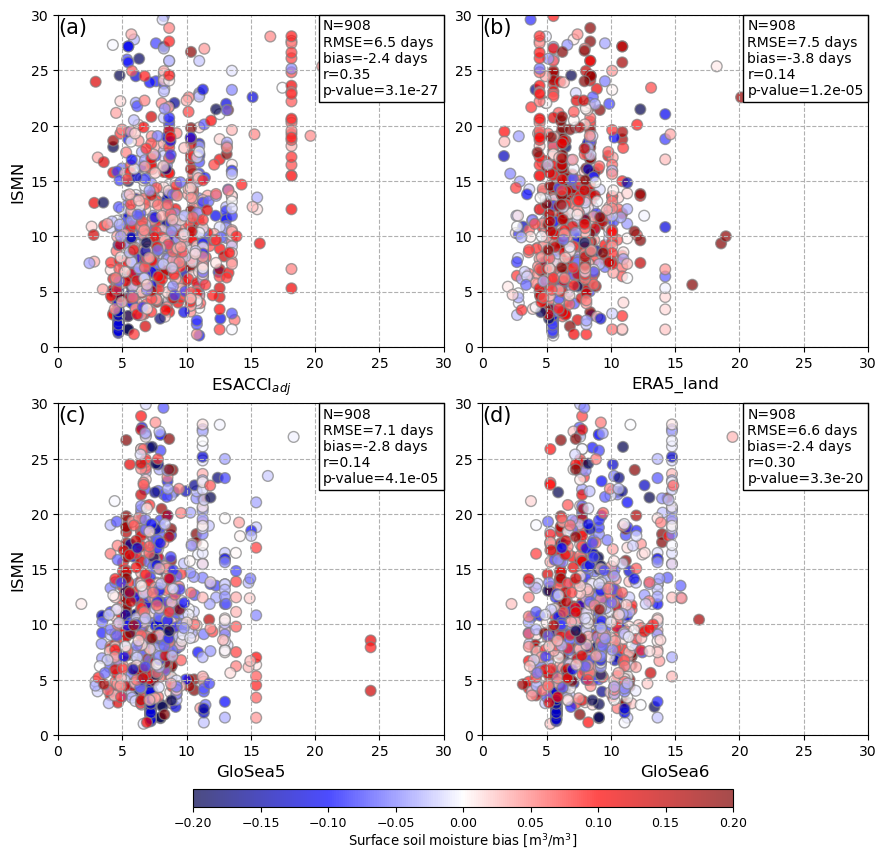

In [288]:
import string
from scipy import stats
alphabet = list(string.ascii_lowercase)


def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


fname = './fig/sm_memory_scatter_bias.png'
xlabels = ['ESACCI$_{adj}$','ERA5_land','GloSea5','GloSea6']
ylabels = ['ISMN','','ISMN','']
xlim = [0, 30]
ylim = [0, 30]
vran = [-0.2, 0.2]
colormap = 'seismic'
nrows = 2
ncols = 2

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        figsize=(9,9))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    if pp==0:
        x1 = sat_smm4
        y1 = obs_smm4
        z1 = sat_clim - obs_clim
    elif pp==1:
        x1 = era_smm4
        y1 = obs_smm4
        z1 = era_clim - obs_clim
    elif pp==2:
        x1 = g5_smm4
        y1 = obs_smm4
        z1 = g5_clim / 100. - obs_clim
    elif pp==3:
        x1 = g6_smm4
        y1 = obs_smm4
        z1 = g6_clim / 100. - obs_clim
        
    rmse = cal_rmse(y1,x1,'site')
    bias = cal_bias(y1,x1,'site')
    corr = stats.pearsonr(x1,y1)[0]
    pval = stats.pearsonr(x1,y1)[1]
    
    sc = axs[pp].scatter(x1, y1, s=60, c=z1, cmap=colormap, edgecolor='gray', alpha=0.7, vmin = vran[0], vmax =vran[1])
    axs[pp].set_xlim(xlim[0],xlim[1])
    axs[pp].set_ylim(ylim[0],ylim[1])
    axs[pp].set_xlabel(xlabels[pp],fontsize=12)
    axs[pp].set_ylabel(ylabels[pp],fontsize=12)
    axs[pp].set_title('({})'.format(alphabet[pp]),fontsize=15,loc='left',y=0.92)
    
    textstr1="\n".join((
        f'N=%.i' %(len(x)), 
        f'RMSE=%.1f days' %(rmse), 
        f'bias=%.1f days' %(bias), 
        f'r=%.2f' %(corr), 
        f'p-value=%.1e' %(pval) 
    ))
    
    props=dict(boxstyle="square",facecolor="white")
    plt.text(0.687,0.76,textstr1,fontsize=10, bbox=props, transform=axs[pp].transAxes)
    axs[pp].grid(True, linestyle='--')
    
fig.subplots_adjust(bottom=0.15, top=0.95, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.17) # wspace: horizontal space, hspace: vertical space,



# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.07, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(sc, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Surface soil moisture bias [{}]'.format('m$^3$/m$^3$'), fontsize=9.5, labelpad=1)
cbar.ax.tick_params(labelsize=9)

# Add a big title at the top
# plt.suptitle('UFS prototype TCI(SSM,SH) bias map',fontsize=14)
plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

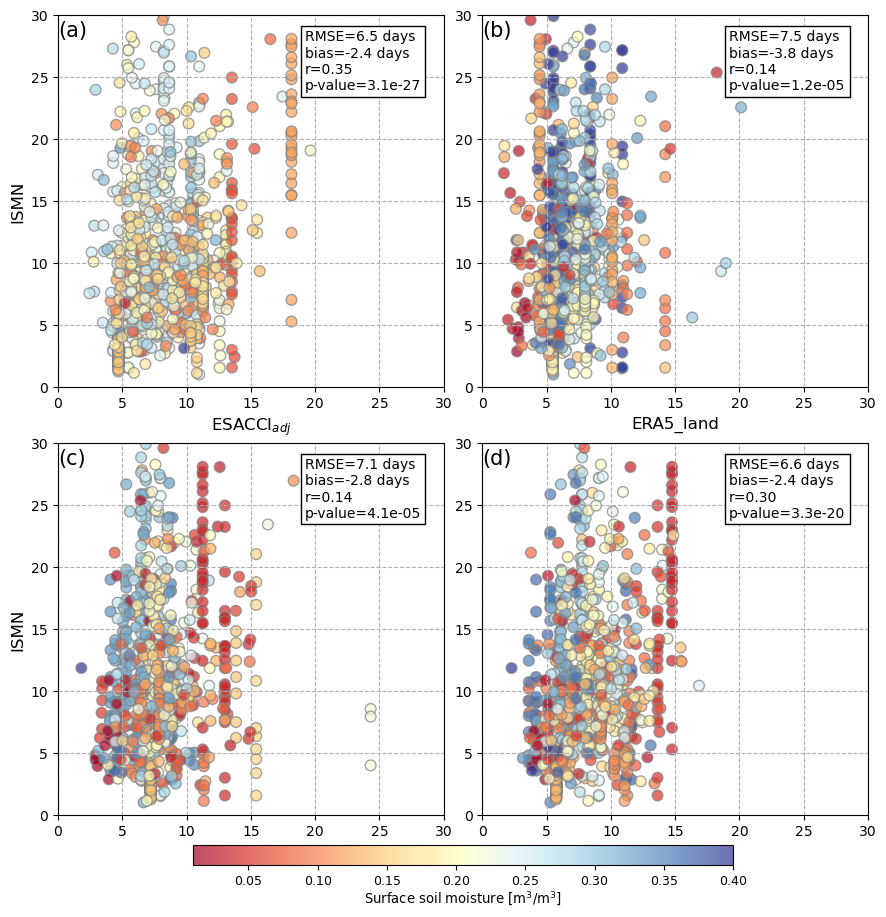

SystemExit: 

In [257]:
import string
from scipy import stats
alphabet = list(string.ascii_lowercase)


def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes



fname = './fig/sm_memory_scatter.png'
xlabels = ['ESACCI$_{adj}$','ERA5_land','GloSea5','GloSea6']
ylabels = ['ISMN','','ISMN','']
xlim = [0, 30]
ylim = [0, 30]
vran = [0.01, 0.4]
colormap = 'RdYlBu'
nrows = 2
ncols = 2

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        figsize=(9,10))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    if pp==0:
        x1 = sat_smm4
        y1 = obs_smm4
        z1 = sat_clim
    elif pp==1:
        x1 = era_smm4
        y1 = obs_smm4
        z1 = era_clim
    elif pp==2:
        x1 = g5_smm4
        y1 = obs_smm4
        z1 = g5_clim / 100.
    elif pp==3:
        x1 = g6_smm4
        y1 = obs_smm4
        z1 = g6_clim / 100.
        
    rmse = cal_rmse(y1,x1,'site')
    bias = cal_bias(y1,x1,'site')
    corr = stats.pearsonr(x1,y1)[0]
    pval = stats.pearsonr(x1,y1)[1]
    
    sc = axs[pp].scatter(x1, y1, s=60, c=z1, cmap=colormap, edgecolor='gray', alpha=0.7, vmin = vran[0], vmax =vran[1])
    axs[pp].set_xlim(xlim[0],xlim[1])
    axs[pp].set_ylim(ylim[0],ylim[1])
    axs[pp].set_xlabel(xlabels[pp],fontsize=12)
    axs[pp].set_ylabel(ylabels[pp],fontsize=12)
    axs[pp].set_title('({})'.format(alphabet[pp]),fontsize=15,loc='left',y=0.92)
    
    textstr1="\n".join((
        f'RMSE=%.1f days' %(rmse), 
        f'bias=%.1f days' %(bias), 
        f'r=%.2f' %(corr), 
        f'p-value=%.1e' %(pval) 
    ))
    
    props=dict(boxstyle="square",facecolor="white")
    plt.text(0.64,0.8,textstr1,fontsize=10, bbox=props, transform=axs[pp].transAxes)
    axs[pp].grid(True, linestyle='--')
    
fig.subplots_adjust(bottom=0.15, top=0.95, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.15) # wspace: horizontal space, hspace: vertical space,



# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(sc, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Surface soil moisture [{}]'.format('m$^3$/m$^3$'), fontsize=9.5, labelpad=1)
cbar.ax.tick_params(labelsize=9)

# Add a big title at the top
plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()